In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from joblib import Parallel, delayed
from scipy.signal import lfilter
from ssms.basic_simulators.simulator import simulator
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from drift_diffusion.model import DriftDiffusionModel
from drift_diffusion.sim import sample_from_ssm

plt.rcParams.update({"font.size": 12, "font.family": "Helvetica"})

In [2]:
rng = np.random.default_rng(seed=3)

# simulation setting
n_samples, n_repeats = 1_000, 900
params = {"a": 1.37, "t0": 0.1, "v": 0.3, "z": 0}  # from rat 195
param_names = list(params.keys())
cov_names = [f"{i},{j}" for i in param_names for j in param_names]

# ar1 setting
rho = 0.99
a_noise_var = (0.14**2) * (1 - rho**2)  # variance of white noise e
v_noise_var = (0.27**2) * (1 - rho**2)
e = rng.standard_normal(size=n_samples)
e -= e.mean()

a_ar1 = lfilter([1], [1, -rho], e * np.sqrt(a_noise_var)) + params["a"]
v_ar1 = lfilter([1], [1, -rho], e * np.sqrt(v_noise_var)) + params["v"]

# simulate outcomes from ddm
ys = sample_from_ssm(a=a_ar1, t0=params["t0"], v=params["v"], z=params["z"], n_samples=n_samples, n_repeats=n_repeats)
ys.shape

(1000, 900)

In [3]:
# initlaize ddm
X = pd.DataFrame(np.ones(n_samples))
ddm = DriftDiffusionModel(cov_estimator="all")


@delayed
def run_simulation(rep):
    ddm.fit(X, ys[:, rep])
    covs_ = [
        {"estimator": k, **{cov_names[i]: val for i, val in enumerate(utils.cov_to_corr(v).flatten())}}
        for k, v in ddm.covariance_.items()
    ]

    return ddm.params_, covs_


with Parallel(n_jobs=-4) as parallel:
    results = parallel(run_simulation(rep) for rep in range(n_repeats))

params_, covs_ = zip(*results)
params_df = pd.DataFrame(params_, columns=param_names)
covs_df = pd.DataFrame([row for c in covs_ for row in c])

/Users/griegner/git-repositories/drift-diffusion/.pixi/envs/dev/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


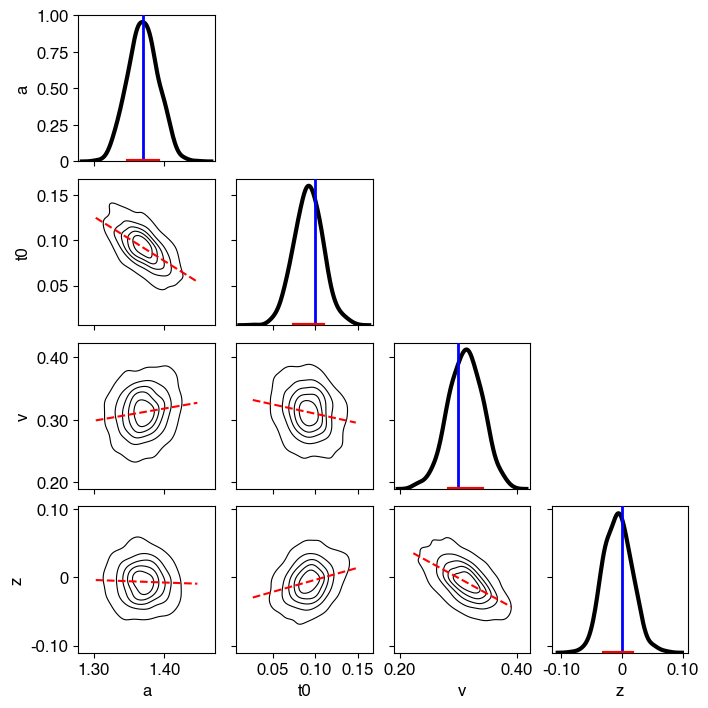

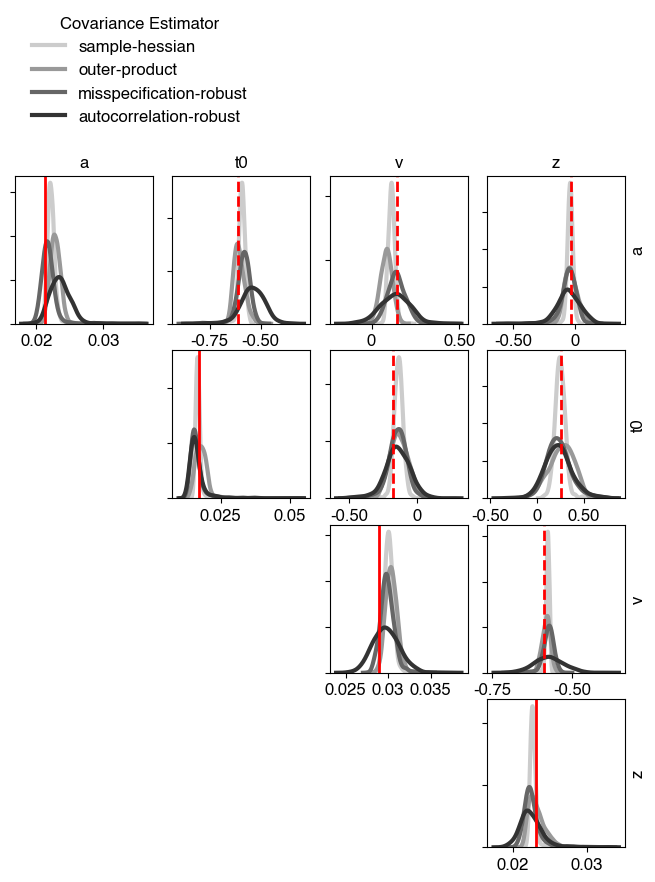

In [5]:
utils.plot_parameter_distributions(params_df, params)
utils.plot_covariance_distributions(covs_df, params_df, param_names)